# Influence Functions (Keras Implementation)

## High Level Summary

- Influence functions measure how a training example affects the predictions for a test example
- More concretely, it measures **how much the test loss would change** if we were to **“upweight” a certain training example**
- The influence function is composed of three components: 
    1. the **gradient of the training example**, 
    2. the **gradient of the test example**, 
    3. the **“similarity” of the examples** from the model’s perspective. 
*Larger gradients and similarity lead to larger influence*
- Influence functions can depend heavily on the model
    - For example, if the model is an SVM classifying images, then examples with closer euclidean distances will have bigger impacts on a specific test example. If a CNN like Inception is tested, examples that are *semantically closer* (not necessarily close in terms of pixel values) will have larger influences
- Influence functions require the computation of a **hessian gradient product**, which has multiple tricks for computing efficiently (thanks to years of research!)
- Influence functions have the following usages (among many others):
    - Finding mislabeled examples
    - Handling domain mismatch
    - Creating adversarial training examples
- Though influence functions assume the convexity of the loss, **if certain modifications are made** they work surprisingly well for non-convex models as well.


## Influence Function Format

Here is the influence function
$$
I_{\text{up,loss}}=-\nabla_{\theta}L(z_{\text{test}},\hat{\theta})^TH_{\theta}^{-1}\nabla_{\theta}L(z,\hat{\theta})
$$

Here, $L$ refers to the loss function and $\theta$ represents the learned parameters. $ \nabla_{\theta}L $ and $H_{\theta}$ are the gradient and Hessian of the loss function

## Efficiently calculating Influence Functions

We can express the test loss for example $z_{test}$ when we update training example $ z $ as
$$
L' = \frac{1}{n}\sum_{i=1}^{n}L(\theta, z_i) + \epsilon L(\theta, z) 
$$
We will define the influence function to be $\frac{dL'}{d\epsilon}$.

**Assumptions:**
During this derivation, we will assume 
1. that the loss is convex (i.e. that there is a single optimal set of parameters that optimize it) and that 
2. it is twice differentiable (i.e. that the Hessian exists).

**Parameters:** We’ll use the following symbols during our analysis: $\hat{\theta}$ and $\hat{\theta_{\epsilon, z}}$.

$\hat{\theta}$ is the set of optimal parameters for the unmodified loss (basically the parameters we obtained by training).

$\hat{\theta_{\epsilon, z}}$ refers to the set of optimal parameters we would get if we upweighted training sample $z$ by $\epsilon$. 

Thanks to the assumption that the loss is convex, both of these symbols have unique values.

$$\hat{\theta} = \text{argmin}_\theta(\frac{1}{n}\sum_{i=1}^{n}L(\theta, z_i)) $$

$$\hat{\theta}_{\epsilon, z} = \text{argmin}_\theta(\frac{1}{n}\sum_{i=1}^{n}L(\theta, z_i) + \epsilon L(\theta, z)) $$

We’ll be using the original loss function several times, so we define the following symbol, $R(\theta)$ to reflect the loss with the parameters $\theta$.

$$R(\theta) = \frac{1}{n}\sum_{i=1}^{n}L(\theta, z_i)$$ 

With this expression in hand, we can compute $\hat{\theta}_{\epsilon, z}$ as the set of parameters that follow the following equation
$$\nabla R(\hat{\theta_{\epsilon, z}}) + \epsilon\nabla L(z, \hat{\theta_{\epsilon, z}}) = 0 $$
since the loss will be minimum if and only if the gradient is $0$.

Now all we have to do is to obtain a closed-form expression of the parameters that satisfy the above condition. We don’t know what the actual loss function looks like, but what we can do is to approximate it using Taylor expansion (this is a classic and recurring technique in optimization, so it’s a good idea to familiarize yourself with it). When conducting Taylor expansion, we must choose a point to expand around. In this case, the most natural point to expand around is $\hat{\theta}$, since we haven’t used any of its properties yet and because it is the amount we know the most about:

$$\nabla R(\hat{\theta_{\epsilon, z}}) + \epsilon\nabla L(z, \hat{\theta_{\epsilon, z}}) \approx  \nabla R(\hat{\theta}) + \epsilon\nabla L(z, \hat{\theta}) + [\nabla^2 R(\hat{\theta}) + \epsilon\nabla^2 L(z, \hat{\theta})](\hat{\theta_{\epsilon, z}} - \hat{\theta}) $$

Since $\hat{\theta} $ minimizes the original loss, $\nabla R(\hat{\theta}) = 0$ . Tidying up the equation, we get

$$\hat{\theta_{\epsilon, z}} - \hat{\theta} = -[\nabla^2R(\hat{\theta}) + \epsilon \nabla^2L(z, \hat{\theta})]^{-1}[\nabla R(\hat{\theta}) + \epsilon \nabla L(z, \hat{\theta})] $$

We assume $\epsilon$ is very small, so we can ignore all terms that are on the order of $ \epsilon^2 $. This means that

$$\hat{\theta_{\epsilon, z}} - \hat{\theta} \approx -\nabla^2R(\hat{\theta})^{-1}\nabla L(z, \hat{\theta})\epsilon $$

From this, we can compute how the parameters change when the weight of the training sample changes:

$$\frac{d\hat{\theta_{\epsilon, z}}}{d\epsilon} = -\nabla^2R(\hat{\theta})^{-1}\nabla L(z, \hat{\theta}) $$

Since $-\nabla^2R(\hat{\theta})$ is really just the hessian,

$$\frac{d\hat{\theta_{\epsilon, z}}}{d\epsilon} = -H(\hat{\theta})^{-1}\nabla L(z, \hat{\theta}) $$

After the Taylor expansion, everything was just simple arithmetic, nothing too difficult. The only remaining step is computing the change in loss, something that’s easy when we use the chain rule:

$$\frac{dL'}{d\epsilon} = \frac{dL(z_{test}, \hat{\theta_{\epsilon, z}})}{d\epsilon} = \frac{dL(z_{test}, \hat{\theta_{\epsilon, z}})}{d\hat{\theta_{\epsilon, z}}} \frac{d\hat{\theta_{\epsilon, z}}}{d\epsilon} = - \nabla_{\theta}L(z_{test}, \hat{\theta})^TH_{\theta}^{-1}\nabla_{\theta}L(z, \hat{\theta}) $$

This step actually involves the multivariate chain rule, which is a bit different from the scalar chain rule. 

And voila, we obtain the desired equation. If you notice, the only slightly involved math we used was a Taylor expansion and the fact that $\hat{\theta}$ minimizes the original loss. Otherwise, this derivation is not as difficult as it might seem.



## Efficiently calculating Influence Functions

Though the influence function is great in theory, it has no practical use if we can’t compute it. Unfortunately, the influence function requires computing the Hessian, which is a matrix filled with second-order derivatives. Computing the Hessian is a (quite obviously) extremely heavy operation, especially with models like deep neural networks with millions of parameters.

Fortunately, the Hessian is a well studied mathematical and computational construct, and over the years, many tricks have been devised to deal with it. In our case, we use the following trick: we can skip computing the hessian and instead directly compute the product of the Hessian with another vector efficiently.

Two methods are outlined in the paper, and I’ll give a brief overview of both without delving too deep into the details (that would make a whole new blog post!):

### Conjugate gradients
In this method, we use the fact that the Hessian-vector product $H^{-1}v$ minimizes the following convex equation with regards to $t$ :
$\frac{1}{2}t^THt - v^Tt $
When the equation is convex, an optimization technique called conjugate gradients can find the optimal solution in linear time with respect to the number of parameters, effectively computing the desired vector.

### Stochastic estimation
Though conjugate gradients are a vast improvement over naive computation, it is still expensive since we still have to iterate over all the training examples. If the training set were sufficiently large, we would be better off estimating the hessian vector product using stochastic estimation based on part of the training set. Though I’ll skip the derivation, we can iteratively estimate the Hessian-vector product using a sequence of samples from the training set $z_1$, $z_2$, ... . Here’s the equation:
$$
H_j^{-1}v = v + (I - \nabla^2_{\theta}L(z_j, \hat{\theta})H_{j-1}^{-1}v) 
$$
$\nabla^2_{\theta}$ is the set of second-order derivatives for the example $z_j$ and can be computed using automatic differentiation mechanisms like PyTorch and tensorflow. The authors found this method to be much faster than conjugate gradients.
If you’re interested in how this would actually be implemented, here is the code in tensorflow provided by the authors of the paper.


## Examples

In [0]:
#Keras CNN Training

from __future__ import print_function
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


In [0]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 10s 161us/step - loss: 0.2671 - acc: 0.9162 - val_loss: 0.0561 - val_acc: 0.9812
Epoch 2/12
60000/60000 [==============================] - 5s 81us/step - loss: 0.0910 - acc: 0.9728 - val_loss: 0.0406 - val_acc: 0.9864
Epoch 3/12
60000/60000 [==============================] - 5s 79us/step - loss: 0.0656 - acc: 0.9804 - val_loss: 0.0341 - val_acc: 0.9891
Epoch 4/12
60000/60000 [==============================] - 5s 79us/step - loss: 0.0535 - acc: 0.9833 - val_loss: 0.0341 - val_acc: 0.9889
Epoch 5/12
60000/60000 [===

In [0]:
y_pred = model.output #Or model.layers[index].output

In [0]:
model.output.shape

TensorShape([Dimension(None), Dimension(10)])

In [0]:
model.loss

<function keras.losses.categorical_crossentropy>

In [0]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [0]:
model = load_model('my_model.h5')

In [0]:
#@title `DarkonLogger` Definition
import logging
from logging.handlers import RotatingFileHandler


class DarkonLogger:
    """ darkon package logger
    """
    def __init__(self):
        _formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)-4s: %(message)s')
        # _file_handler = logging.handler.FileHandler(__package__ + '.log')
        _file_handler = RotatingFileHandler('darkon.log', maxBytes=1024*1024*100)
        _file_handler.setFormatter(_formatter)
        _file_handler.setLevel(logging.DEBUG)
        _stream_handler = logging.StreamHandler()
        _stream_handler.setFormatter(_formatter)
        _stream_handler.setLevel(logging.INFO)

        _logger = logging.getLogger(__package__)
        _logger.setLevel(logging.DEBUG)
        _logger.addHandler(_file_handler)
        _logger.addHandler(_stream_handler)
        self._logger = _logger

        _logger.debug('----------------------------')
        _logger.debug('start logging darkon package')

    @property
    def logger(self):
        return self._logger


logger = DarkonLogger().logger

In [0]:
#@title `InfluenceFeeder` Definition
from __future__ import absolute_import
from __future__ import unicode_literals

import abc
import six


@six.add_metaclass(abc.ABCMeta)
class InfluenceFeeder:
    @abc.abstractmethod
    def reset(self):
        """ reset dataset
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def train_batch(self, batch_size):
        """ training data feeder by batch sampling
        Parameters
        ----------
        batch_size : batch size
        Returns
        -------
        xs : feed input values
        ys : feed label values
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def train_one(self, index):
        """ single training data feeder
        Parameters
        ----------
        index : training sample index
        Returns
        -------
        x : feed one input value
        y : feed one label value
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def test_indices(self, indices):
        """ test data feeder
        Parameters
        ----------
        indices : testing sample index
        Returns
        -------
        x : feed input values
        y : feed label values
        """
        raise RuntimeError('must be implemented')

In [0]:
#@title `MyFeeder` definition

class MNISTFeeder(InfluenceFeeder):
    def __init__(self, train_data, train_label, test_data, test_label):
        num_classes = 10
        # input image dimensions
        img_rows, img_cols = 28, 28
        self.train_origin_data = train_data
        self.train_origin_label = train_label
        # load test data
        self.test_origin_data = test_data
        self.test_origin_label = test_label
        
        if K.image_data_format() == 'channels_first':
            self.train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols).astype('float32')/255
            self.test_data = test_data.reshape(test_data.shape[0], 1, img_rows, img_cols).astype('float32')/255
        else:
            self.train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, 1).astype('float32')/255
            self.test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1).astype('float32')/255
        
        self.train_label = keras.utils.to_categorical(train_label, num_classes)
        self.test_label = keras.utils.to_categorical(test_label, num_classes)
        
        self.train_batch_offset = 0

    def test_indices(self, indices):
        return self.test_data[indices], self.test_label[indices]

    def train_batch(self, batch_size):
        # calculate offset
        start = self.train_batch_offset
        end = start + batch_size
        self.train_batch_offset += batch_size

        return self.train_data[start:end, ...], self.train_label[start:end, ...]

    def train_one(self, idx):
        return self.train_data[idx, ...], self.train_label[idx, ...]

    def reset(self):
        self.train_batch_offset = 0

(x_train, y_train), (x_test, y_test) = mnist.load_data()        

feeder = MNISTFeeder(x_train, y_train, x_test, y_test)

In [0]:
#@title Initial Imports and `_timing()` definition

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import keras
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.gradients_impl import _hessian_vector_product
import time
import os
import time
import hashlib
import json
from functools import wraps

_using_fully_tf = True


def _timing(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        logger.debug('* %s function took [%.3fs]' % (f.__name__, time2-time1))
        return ret
    return wrap

In [0]:
#@title Influence Class (Keras)
kerasLossDict = {
    'categorical_crossentropy': keras.losses.categorical_crossentropy,
    'sparse_categorical_crossentropy': keras.losses.sparse_categorical_crossentropy,
    'binary_crossentropy': keras.losses.binary_crossentropy,
    'kullback_leibler_divergence': keras.losses.kullback_leibler_divergence,
    'poisson': keras.losses.poisson,
    'cosine_proximity': keras.losses.cosine_proximity
}

class Influence:
    """ Influence Class (for keras models)
    """
    def __init__(self, feeder, model):
        self.workspace = './influence-workspace'
        self.feeder = feeder
        self.x_placeholder = model.input
        self.y_placeholder = K.placeholder(shape=model.output.shape)
        self.test_feed_options = dict()
        self.train_feed_options = dict()
        
        if model.loss in kerasLossDict.keys():
            loss_op_train = kerasLossDict[model.loss](self.y_placeholder, model.output)
            loss_op_test = kerasLossDict[model.loss](self.y_placeholder, model.output)
        else:
            loss_op_train = model.loss(self.y_placeholder, model.output)
            loss_op_test = model.loss(self.y_placeholder, model.output)

        trainable_variables = model.trainable_weights

        self.loss_op_train = loss_op_train
        self.grad_op_train = K.gradients(loss_op_train, trainable_variables)
        self.grad_op_test = K.gradients(loss_op_test, trainable_variables)

        self.v_cur_estimated = [tf.placeholder(tf.float32, shape=a.get_shape()) for a in trainable_variables]
        self.v_test_grad = [tf.placeholder(tf.float32, shape=a.get_shape()) for a in trainable_variables]
        self.v_ihvp = tf.placeholder(tf.float64, shape=[None])
        self.v_param_damping = tf.placeholder(tf.float32)
        self.v_param_scale = tf.placeholder(tf.float32)
        self.v_param_total_trainset = tf.placeholder(tf.float64)

        self.inverse_hvp = None
        self.trainable_variables = trainable_variables

        with tf.name_scope('darkon_ihvp'):
            self.hessian_vector_op = _hessian_vector_product(loss_op_train, trainable_variables, self.v_cur_estimated)
            self.estimation_op = [
                a + (b * self.v_param_damping) - (c / self.v_param_scale)
                for a, b, c in zip(self.v_test_grad, self.v_cur_estimated, self.hessian_vector_op)
            ]

        with tf.name_scope('darkon_grad_diff'):
            flatten_inverse_hvp = tf.reshape(self.v_ihvp, shape=(-1, 1))
            flatten_grads = tf.concat([tf.reshape(a, (-1,)) for a in self.grad_op_train], 0)
            flatten_grads = tf.reshape(flatten_grads, shape=(1, -1,))
            flatten_grads = tf.cast(flatten_grads, tf.float64)
            flatten_grads /= self.v_param_total_trainset
            self.grad_diff_op = tf.matmul(flatten_grads, flatten_inverse_hvp)

        self.ihvp_config = {
            'scale': 1e4,
            'damping': 0.01,
            'num_repeats': 1,
            'recursion_batch_size': 10,
            'recursion_depth': 10000
        }

        if not os.path.exists(self.workspace):
            os.makedirs(self.workspace)


    @_timing
    def upweighting_influence(self, sess, test_indices, test_batch_size, approx_params,
                              train_indices, num_total_train_example, force_refresh=False):
        """ Calculate influence score of given training samples that affect on the test samples
         Negative value indicates bad effect on the test loss
        """
        self._prepare(sess, test_indices, test_batch_size, approx_params, force_refresh)

        self.feeder.reset()
        score = self._grad_diffs(sess, train_indices, num_total_train_example)
        logger.info('Multiplying by %s train examples' % score.size)
        return score


    @_timing
    def upweighting_influence_batch(self, sess, test_indices, test_batch_size, approx_params,
                                    train_batch_size, train_iterations, subsamples=-1, force_refresh=False):
        """ Iteratively calculate influence scores for training data sampled by batch sampler
        Negative value indicates bad effect on the test loss
        """
        self._prepare(sess, test_indices, test_batch_size, approx_params, force_refresh)

        self.feeder.reset()
        score = self._grad_diffs_all(sess, train_batch_size, train_iterations, subsamples)
        logger.info('Multiplying by %s train examples' % score.size)
        return score


    @_timing
    def _prepare(self, sess, test_indices, test_batch_size, approx_params, force_refresh):
        """ Calculate inverse hessian vector product, and save it in workspace
        """
        # update ihvp approx params
        if approx_params is not None:
            for param_key in approx_params.keys():
                if param_key not in self.ihvp_config:
                    raise RuntimeError('unknown ihvp config param is approx_params')
            self.ihvp_config.update(approx_params)

        inv_hvp_path = self._path(self._approx_filename(sess, test_indices))
        if not os.path.exists(inv_hvp_path) or force_refresh:
            self.feeder.reset()
            test_grad_loss = self._get_test_grad_loss(sess, test_indices, test_batch_size)
            logger.info('Norm of test gradient: %s' % np.linalg.norm(np.concatenate([a.reshape(-1) for a in test_grad_loss])))
            self.inverse_hvp = self._get_inverse_hvp_lissa(sess, test_grad_loss)
            np.savez(inv_hvp_path, inverse_hvp=self.inverse_hvp, encoding='bytes')
            logger.info('Saved inverse HVP to %s' % inv_hvp_path)
        else:
            self.inverse_hvp = np.load(inv_hvp_path, encoding='bytes')['inverse_hvp']
            logger.info('Loaded inverse HVP from %s' % inv_hvp_path)


    def _get_test_grad_loss(self, sess, test_indices, test_batch_size):
        if test_indices is not None:
            num_iter = int(np.ceil(len(test_indices) / test_batch_size))
            test_grad_loss = None
            for i in range(num_iter):
                start = i * test_batch_size
                end = int(min((i + 1) * test_batch_size, len(test_indices)))
                size = float(end - start)

                test_feed_dict = self._make_test_feed_dict(*self.feeder.test_indices(test_indices[start:end]))
                temp = sess.run(self.grad_op_test, feed_dict=test_feed_dict)
                temp = np.asarray(temp)

                temp *= size
                if test_grad_loss is None:
                    test_grad_loss = temp
                else:
                    test_grad_loss += temp

            test_grad_loss /= len(test_indices)
        else:
            raise RuntimeError('unsupported yet')
        return test_grad_loss

    
    def _approx_filename(self, sess, test_indices):
        sha = hashlib.sha1()

        # weights
        vs = sess.run(self.trainable_variables)
        for a in vs:
            sha.update(a.data)

        # test_indices
        np_test_indices = np.array(list(test_indices))
        sha.update(np_test_indices.data)

        # approx_params
        sha.update(json.dumps(self.ihvp_config, sort_keys=True).encode('utf-8'))
        return 'ihvp.' + sha.hexdigest() + '.npz'

    
    def _get_inverse_hvp_lissa(self, sess, test_grad_loss):
        ihvp_config = self.ihvp_config
        print_iter = ihvp_config['recursion_depth'] / 10

        inverse_hvp = None
        for sample_idx in range(ihvp_config['num_repeats']):
            cur_estimate = test_grad_loss
            debug_diffs_estimation = [] ## FOR DEBUGGING
            prev_estimation_norm = np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate])) ## FOR DEBUGGING

            for j in range(ihvp_config['recursion_depth']):
                train_batch_data, train_batch_label = self.feeder.train_batch(ihvp_config['recursion_batch_size'])
                feed_dict = self._make_train_feed_dict(train_batch_data, train_batch_label)
                feed_dict = self._update_feed_dict(feed_dict, cur_estimate, test_grad_loss)

                if _using_fully_tf:
                    feed_dict.update({
                        self.v_param_damping: 1 - self.ihvp_config['damping'],
                        self.v_param_scale: self.ihvp_config['scale']
                    })
                    cur_estimate = sess.run(self.estimation_op, feed_dict=feed_dict)
                else:
                    hessian_vector_val = sess.run(self.hessian_vector_op, feed_dict=feed_dict)
                    hessian_vector_val = np.array(hessian_vector_val)
                    cur_estimate = test_grad_loss + (1 - ihvp_config['damping']) * cur_estimate - hessian_vector_val / ihvp_config['scale']

                curr_estimation_norm = np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate])) ## FOR DEBUGGING
                debug_diffs_estimation.append(curr_estimation_norm - prev_estimation_norm) ## FOR DEBUGGING
                prev_estimation_norm = curr_estimation_norm ## FOR DEBUGGING
                
                if (j % print_iter == 0) or (j == ihvp_config['recursion_depth'] - 1):
                    logger.info("Recursion at depth %s: norm is %.8lf" %
                                (j, np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate]))))

            if inverse_hvp is None:
                inverse_hvp = np.array(cur_estimate) / ihvp_config['scale']
            else:
                inverse_hvp += np.array(cur_estimate) / ihvp_config['scale']

            np.savetxt(self._path('debug_diffs_estimation_{}.txt'.format(sample_idx)), debug_diffs_estimation) ## FOR DEBUGGING

        inverse_hvp /= ihvp_config['num_repeats']
        return inverse_hvp

    
    def _update_feed_dict(self, feed_dict, cur_estimated, test_grad_loss):
        for placeholder, var in zip(self.v_cur_estimated, cur_estimated):
            feed_dict[placeholder] = var

        for placeholder, var in zip(self.v_test_grad, test_grad_loss):
            feed_dict[placeholder] = var
        return feed_dict

    
    @_timing
    def _grad_diffs(self, sess, train_indices, num_total_train_example):
        inverse_hvp = np.concatenate([a.reshape(-1) for a in self.inverse_hvp])

        num_to_remove = len(train_indices)
        predicted_grad_diffs = np.zeros([num_to_remove])

        for counter, idx_to_remove in enumerate(train_indices):
            single_data, single_label = self.feeder.train_one(idx_to_remove)
            feed_dict = self._make_train_feed_dict([single_data], [single_label])
            predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)

            if (counter % 1000) == 0:
                logger.info('counter: {} / {}'.format(counter, num_to_remove))

        return predicted_grad_diffs

    
    @_timing
    def _grad_diffs_all(self, sess, train_batch_size, num_iters, num_subsampling):
        num_total_train_example = num_iters * train_batch_size
        if num_subsampling > 0:
            num_diffs = num_iters * num_subsampling
        else:
            num_diffs = num_iters * train_batch_size

        inverse_hvp = np.concatenate([a.reshape(-1) for a in self.inverse_hvp])
        predicted_grad_diffs = np.zeros([num_diffs])

        counter = 0
        for it in range(num_iters):
            train_batch_data, train_batch_label = self.feeder.train_batch(train_batch_size)

            if num_subsampling > 0:
                for idx in range(num_subsampling):
                    feed_dict = self._make_train_feed_dict(train_batch_data[idx:idx + 1], train_batch_label[idx:idx + 1])
                    predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)
                    counter += 1
            else:
                for single_data, single_label in zip(train_batch_data, train_batch_label):
                    feed_dict = self._make_train_feed_dict([single_data], [single_label])
                    predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)
                    counter += 1

            if (it % 10) == 0:
                logger.info('iter: {}/{}'.format(it, num_iters))

        return predicted_grad_diffs

    
    def _grad_diff(self, sess, feed_dict, num_total_train_example, inverse_hvp):
        if _using_fully_tf:
            feed_dict.update({
                self.v_ihvp: inverse_hvp,
                self.v_param_total_trainset: num_total_train_example
            })
            return sess.run(self.grad_diff_op, feed_dict=feed_dict)
        else:
            train_grads = sess.run(self.grad_op_train, feed_dict=feed_dict)
            train_grads = np.concatenate([a.reshape(-1) for a in train_grads])
            train_grads /= num_total_train_example
            return np.dot(inverse_hvp, train_grads)

        
    def _make_test_feed_dict(self, xs, ys):
        ret = {
            self.x_placeholder: xs,
            self.y_placeholder: ys,
        }
        ret.update(self.test_feed_options)
        return ret

    
    def _make_train_feed_dict(self, xs, ys):
        ret = {
            self.x_placeholder: xs,
            self.y_placeholder: ys,
        }
        ret.update(self.train_feed_options)
        return ret

    
    def _path(self, *paths):
        return os.path.join(self.workspace, *paths)

In [0]:
#@title Inspector definition

inspector = Influence(
    feeder=feeder,
    model=model)

[0]


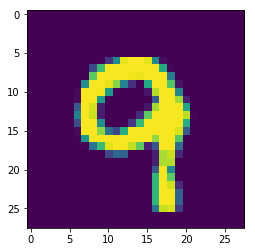

In [0]:
#@title Influence Target & Params

#@markdown The index of the (single) influence target
influence_target = 99 #@param

# display
print([int(np.argmax(feeder.test_origin_label[influence_target]))])
plt.imshow(feeder.test_origin_data[influence_target])

test_indices = [influence_target]
testset_batch_size = 100 #@param {type:"integer"}

train_batch_size = 100 #@param {type:"integer"}
train_iterations = 500 #@param {type:"integer"}

sess = tf.InteractiveSession()

#@markdown **Parameters for the influence function approximator itself:**
scale = 1e5   #@param 
#@markdown Lower **`scale`** makes scores more exaggerated, higher does opposite
#@markdown (Too high can get nan norms, which results in random indexes and non-plottable scores)
damping = 0.01 #@param 
num_repeats = 1 #@param 
recursion_batch_size = 100 #@param 
recursion_depth = 10000 #@param 


approx_params = {
    'scale': scale,   # lower makes scores more exaggerated, higher does opposite (but too high can get nan norms, which results in random indexes and non-plottable scores)
    'damping': damping,
    'num_repeats': num_repeats,
    'recursion_batch_size': recursion_batch_size,
    'recursion_depth': recursion_depth
}

In [0]:
#@title Default title text
tf.initialize_all_variables().run()

scores = inspector.upweighting_influence_batch(
    sess,
    test_indices,
    testset_batch_size,
    approx_params,
    train_batch_size,
    train_iterations)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


2019-05-30 17:18:26,918 tensorflow WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
2019-05-30 17:18:27,143 root INFO: Norm of test gradient: 5.333891
2019-05-30 17:18:27,347 root INFO: Recursion at depth 0: norm is 10.61146164
2019-05-30 17:18:41,029 root INFO: Recursion at depth 1000: norm is 532.83764648
2019-05-30 17:18:48,705 root INFO: Recursion at depth 2000: norm is 533.38726807
2019-05-30 17:18:56,077 root INFO: Recursion at depth 3000: norm is 533.38726807
2019-05-30 17:19:03,223 root INFO: Recursion at depth 4000: norm is 533.38726807
2019-05-30 17:19:10,373 root INFO: Recursion at depth 5000: norm is 533.38726807
2019-05-30 17:19:17,584 root INFO: Recursion at depth 6000: norm is 533.38726807
2019-05-30 17:19:24,736 root INFO: Recursion at

In [0]:
sorted_indices = np.argsort(scores)
harmful = sorted_indices[:10]
helpful = sorted_indices[-10:][::-1]

print('\nHarmful:')
for idx in harmful:
    print('[{}] {}'.format(idx, scores[idx]))
    
print('\nHelpful:')
for idx in helpful:
    print('[{}] {}'.format(idx, scores[idx]))


Harmful:
[19655] -1.850221339089669e-07
[25311] -1.7128531040280493e-07
[48139] -1.6928560599596616e-07
[36149] -1.6899258161357574e-07
[38174] -1.6509575108406467e-07
[1863] -1.6417292485340106e-07
[25291] -1.634257509158586e-07
[3314] -1.6118163665534243e-07
[10887] -1.5859966758296591e-07
[29014] -1.5821797433573282e-07

Helpful:
[26212] 5.09663199120144e-07
[25371] 5.014932868983601e-07
[40006] 5.012253175196627e-07
[25493] 5.00455481654693e-07
[18060] 4.996848998866146e-07
[44348] 4.981465366309371e-07
[33336] 4.910999239031843e-07
[3296] 4.90808014570105e-07
[29956] 4.879888511313572e-07
[40302] 4.868449175355889e-07


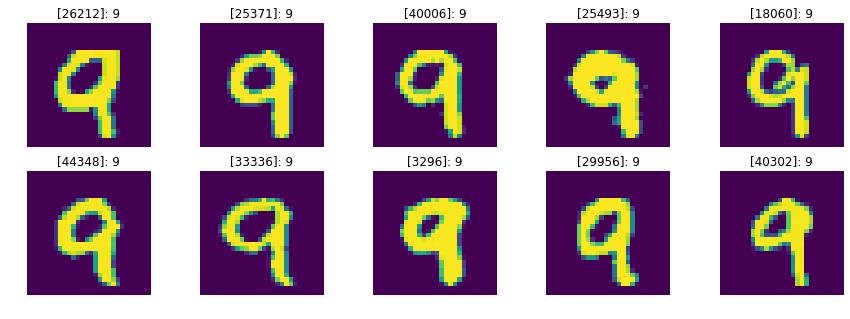

In [0]:
fig, axes1 = plt.subplots(2, 5, figsize=(15, 5))
target_idx = 0
for j in range(2):
    for k in range(5):
        idx = helpful[target_idx]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(feeder.train_origin_data[idx])
        label_str = int(feeder.train_origin_label[idx])
        axes1[j][k].set_title('[{}]: {}'.format(idx, label_str))

        target_idx += 1

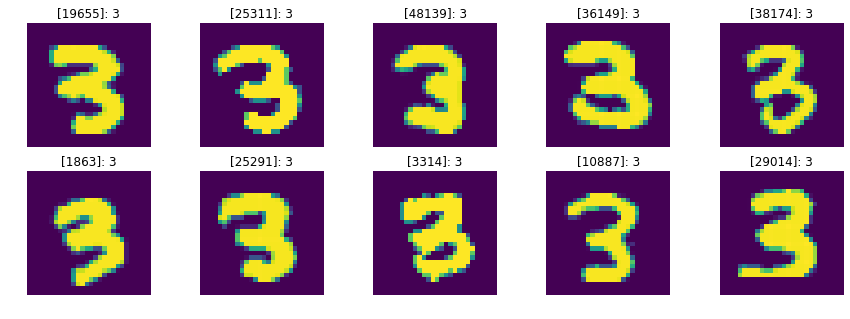

In [0]:
fig, axes1 = plt.subplots(2, 5, figsize=(15, 5))
target_idx = 0
for j in range(2):
    for k in range(5):
        idx = harmful[target_idx]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(feeder.train_origin_data[idx])
        label_str = int(feeder.train_origin_label[idx])
        axes1[j][k].set_title('[{}]: {}'.format(idx, label_str))

        target_idx += 1

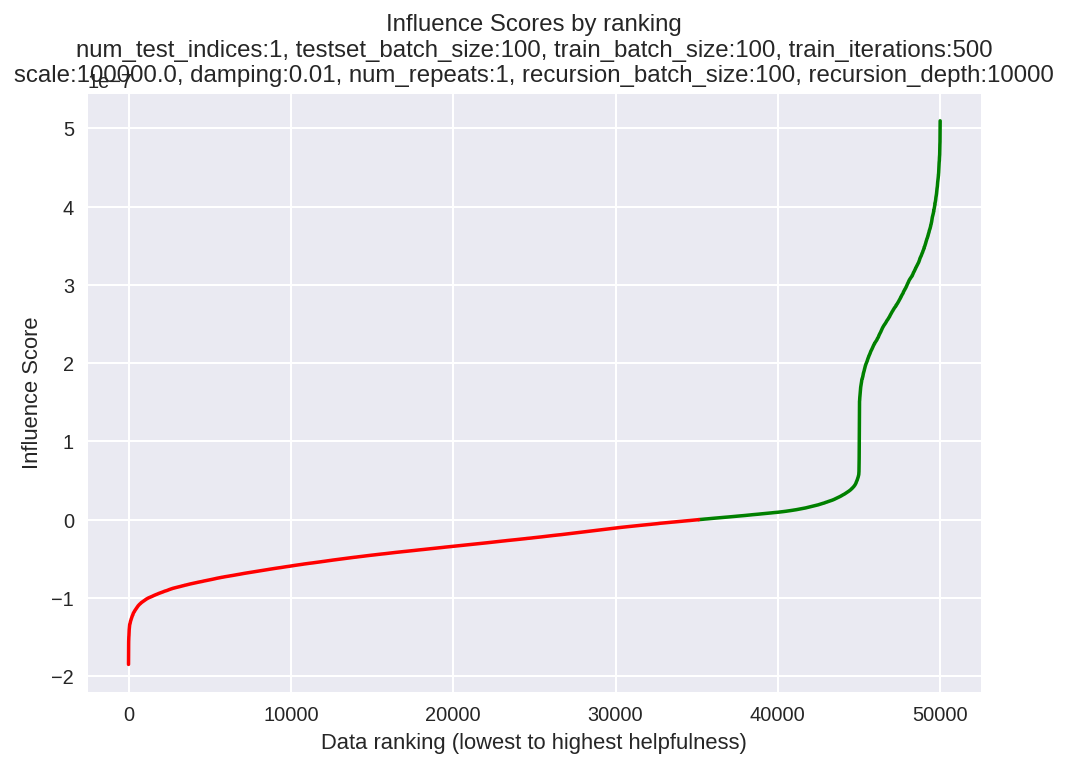

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

pos_signal = scores[sorted_indices].copy()
neg_signal = scores[sorted_indices].copy()

pos_signal[pos_signal <= 0] = np.nan
neg_signal[neg_signal > 0] = np.nan

#plotting
plt.style.use('seaborn')
plt.plot(pos_signal, color='g')
plt.plot(neg_signal, color='r')
plt.xlabel("Data ranking (lowest to highest helpfulness)")
plt.ylabel("Influence Score")
plt.title("Influence Scores by ranking\nnum_test_indices:{}, testset_batch_size:{}, train_batch_size:{}, train_iterations:{}\nscale:{}, damping:{}, num_repeats:{}, recursion_batch_size:{}, recursion_depth:{}".format(
    len(test_indices),
    testset_batch_size,
    train_batch_size,
    train_iterations,
    approx_params['scale'],
    approx_params['damping'],
    approx_params['num_repeats'],
    approx_params['recursion_batch_size'],
    approx_params['recursion_depth']))
plt.savefig('pos_neg.png', dpi=1000)
plt.show()

In [0]:
import pandas as pd

influence_results = pd.DataFrame(
    data=np.transpose(
        np.stack(
            [scores[sorted_indices],
             [i.astype(int) for i in sorted_indices],
             [i.astype(int) for i in feeder.train_origin_label[sorted_indices]],
             np.arange(len(scores),0,-1),
             np.arange(1,len(scores)+1,1)
            ])),
    columns=["score", "index", "label", "pos_rank", "neg_rank"])

In [0]:
#@title Plotting functions for interactive visualization
import numpy as np # we will use this later, so import it now

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.models import (
    ColumnDataSource,
    ColorBar,
    LinearColorMapper,
    LogColorMapper,
)
from bokeh.models.annotations import BoxAnnotation
from bokeh.models.tools import HoverTool
from bokeh.palettes import Viridis3, Viridis256
from bokeh.plotting import figure
from bokeh.transform import transform

output_notebook()

# Create a ColumnDataSource from df: source
source = ColumnDataSource(influence_results)

TOOLS = "box_select,lasso_select,help,pan,wheel_zoom,box_zoom,reset"
TITLE = "Influence scores for training data (colored and ordered by helpfulness)"

p = figure(tools=TOOLS, toolbar_location="above",
           plot_width=800, plot_height=400, title=TITLE)
p.toolbar.logo = "normal"

color_mapper = LinearColorMapper(palette=Viridis256, 
                                 low=np.min(influence_results['score'].values), 
                                 high=np.max(influence_results['score'].values))
#color_mapper.low_color = 'red'
#color_mapper.high_color = 'red'

# region that always fills the top of the plot
upper = BoxAnnotation(bottom=0, fill_alpha=0.025, fill_color='green')
p.add_layout(upper)

# region that always fills the bottom of the plot
lower = BoxAnnotation(top=0, fill_alpha=0.025, fill_color='firebrick')
p.add_layout(lower)

color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
p.add_layout(color_bar, 'right')

# add a circle renderer with x and y coordinates, size, color, and alpha
cr = p.circle('neg_rank', 'score', size=5,
              fill_color={'field': 'score', 'transform': color_mapper}, 
              hover_fill_color="orange",
              line_color={'field': 'score', 'transform': color_mapper}, 
              hover_line_color="orange",
              fill_alpha=1.0, hover_fill_alpha=1.0, source=source)

p.add_tools(HoverTool(tooltips=[("score", "@score"),
                                ('index', '@index'),
                                ("label", "@label"),
                                ('pos_rank', '@pos_rank'),
                                ("neg_rank", "@neg_rank")],
                      renderers=[cr],
                      mode='mouse'))

p.outline_line_width = 3
p.outline_line_alpha = 0.15
p.outline_line_color = "navy"
p.xaxis.axis_label = 'Ranked Index (1=lowest score)'
p.yaxis.axis_label = 'Influence Score'

show(p)

Loading BokehJS ...


-

-

-

-

-

-

# References

**Videos**
- https://vimeo.com/237274831
- https://youtu.be/0w9fLX_T6tY

**Explanations of Influence Functions in ML**
- [Chapter 6.4 From "Interpretable ML" E-book: Influential Instances](https://christophm.github.io/interpretable-ml-book/influential.html)
- [Influence Functions (slides, with some explanations of past relevant work)](https://www.slideshare.net/TerryTaewoongUm/understanding-blackbox-predictions-via-influence-functions-2017)

**Non-ML Influence Functions**
- [Influence Functions for Fun and Profit](http://j-kahn.com/files/influencefunctions.pdf)
- [Statistical functionals and influence functions (slide deck)](https://web.as.uky.edu/statistics/users/pbreheny/621/F12/notes/8-28.pdf)
- [Influence functions and OLS (stackexchange)](https://stats.stackexchange.com/questions/8344/influence-functions-and-ols)
- [Influence function (subsection of the "Robust Statistics" Wikipedia article)](https://en.wikipedia.org/wiki/Robust_statistics#Empirical_influence_function)

**Code Examples**
- [The Darkon Github](https://github.com/darkonhub/darkon)
- [The Darkon-Examples Github](https://github.com/darkonhub/darkon-examples)
- [The Darkon Documentation](http://darkon.io/)
- [Darkon Demo](https://github.com/darkonhub/darkon-demo)
- [CodaLab for "Understanding black-box predictions via influence functions"](https://worksheets.codalab.org/worksheets/0x2b314dc3536b482dbba02783a24719fd/)
- [Pang Wei Koh's Github repo of simpler Influence Function Examples](https://github.com/kohpangwei/influence-release/tree/master/influence)
- [Somebody's homework, which involved reconstrucing the code of the 2017 paper](https://github.com/Georizk/InfluenceFunctions)
- [further examples of someone else's implementation (uses chainer)](https://github.com/corochann/influence_functions)
- [influence function explorations (includes HVP exploration code)](https://github.com/joyivan/influence-function-cntk)

**Relevant links from "Papers with Code"**

[Understanding Black-box Predictions via Influence Functions](https://paperswithcode.com/paper/understanding-black-box-predictions-via)
- [Abstract](https://arxiv.org/abs/1703.04730v2)
- [Paper](https://arxiv.org/pdf/1703.04730v2.pdf)
- [darkonhub/darkon](https://github.com/darkonhub/darkon)
- [bsharchilev/influence_boosting](https://github.com/bsharchilev/influence_boosting)

[Influence Functions for Machine Learning: Nonparametric Estimators for Entropies, Divergences and Mutual Informations](https://paperswithcode.com/paper/influence-functions-for-machine-learning)
- [Abstract](https://arxiv.org/abs/1411.4342v3)
- [Paper](https://arxiv.org/pdf/1411.4342v3.pdf)
- [kirthevasank/if-estimators](https://github.com/kirthevasank/if-estimators)

[SmoothGrad: removing noise by adding noise](https://paperswithcode.com/paper/smoothgrad-removing-noise-by-adding-noise)
- [Abstract](https://arxiv.org/abs/1706.03825v1)
- [Paper](https://arxiv.org/pdf/1706.03825v1.pdf)
- [slundberg/shap (4191 stars)](https://github.com/slundberg/shap)
- [kamata1729/visualize-pytorch](https://github.com/kamata1729/visualize-pytorch)
- [shaoshanglqy/shap-shapley](https://github.com/shaoshanglqy/shap-shapley)
- [nishidayoshikatsu/chainer-smoothgrad-sample](https://github.com/nishidayoshikatsu/chainer-smoothgrad-sample)
 
**Author Info**
- [Pang Wei Koh's Website (the ML influence func paper is the 5th from the top)](http://koh.pw/)

**Papers that Cited the original 2017 influence func paper**
- [Interpreting Neural Networks Using Flip Points](https://arxiv.org/abs/1903.08789)
- [GNN Explainer: A Tool for Post-hoc Explanation of Graph Neural Networks](https://arxiv.org/abs/1903.03894)
- [Faithful and Customizable Explanations of Black Box Models](http://www.aies-conference.com/wp-content/papers/main/AIES-19_paper_143.pdf)